# Measuring creativity

Once you've trained a pass selection, pass outcome and pass value model, they can be combined to measure the creativity of a pass.

In [1]:
from pathlib import Path
from functools import partial

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import mlflow
from scipy.ndimage import zoom

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from unxpass.databases import SQLiteDatabase
from unxpass.datasets import PassesDataset
from unxpass.components import pass_selection, pass_value, pass_success
from unxpass.components.utils import load_model
from unxpass.visualization import plot_action
#from unxpass.ratings_custom import CreativeDecisionRating

In [4]:
plt_settings = {"cmap": "magma", "vmin": 0, "vmax": 1, "interpolation": "bilinear"}

## Load dataset

In [5]:
STORES_FP = Path("../stores")

db = SQLiteDatabase(STORES_FP / "database.sql")

dataset_test = partial(PassesDataset, path=STORES_FP / "datasets" / "euro2020" / "test")
dataset_train = partial(PassesDataset, path=STORES_FP / "datasets" / "euro2020" / "train")

In [6]:
model_pass_selection = pass_selection.SoccerMapComponent(
    model=mlflow.pytorch.load_model(
        'runs:/04d45112c139473590b5049cb3797d0d/model', map_location='cpu'
        #'runs:/788ec5a232af46e59ac984d50ecfc1d5/model', map_location='cpu'
    )
)
#model_pass_selection.test(dataset_test)

In [7]:
bad = [13, 15, 23, 34, 36, 38, 66, 145, 149, 160, 162, 193]
bad_tuple = [(3795506, b) for b in bad]
bad_tuple

[(3795506, 13),
 (3795506, 15),
 (3795506, 23),
 (3795506, 34),
 (3795506, 36),
 (3795506, 38),
 (3795506, 66),
 (3795506, 145),
 (3795506, 149),
 (3795506, 160),
 (3795506, 162),
 (3795506, 193)]

In [8]:
a = db.actions(game_id = 3795506)
a[a["team_id"] == 768].index[190:500]#if team_id == 768, wrong

MultiIndex([(3795506,  399),
            (3795506,  404),
            (3795506,  412),
            (3795506,  413),
            (3795506,  414),
            (3795506,  415),
            (3795506,  417),
            (3795506,  418),
            (3795506,  419),
            (3795506,  420),
            ...
            (3795506, 1420),
            (3795506, 1421),
            (3795506, 1422),
            (3795506, 1424),
            (3795506, 1426),
            (3795506, 1427),
            (3795506, 1428),
            (3795506, 1429),
            (3795506, 1430),
            (3795506, 1444)],
           names=['game_id', 'action_id'], length=310)

In [7]:
surface_pass_selection= model_pass_selection.predict_surface(dataset_test, db = db)


[08/13/24 13:40:30] INFO     Loading dataset from ../stores/datasets/euro2020/test                  ]8;id=196745;file:///home/lz80/un-xPass/.venv/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=256843;file:///home/lz80/un-xPass/.venv/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py#32\32]8;;\

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


balls


Predicting: 0it [00:00, ?it/s]

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


914 914
914 914
914 914
914 914
768 914
768 914
768 914
768 914
768 914
768 914
914 914
914 914
914 914
914 914
914 914
914 914
914 914
768 914
914 914
914 914
914 914
914 914
914 914
914 914
914 914
914 914
914 914
914 914
914 914
914 914
914 914
768 914
914 914
768 914
768 914
768 914
768 914
914 914
914 914
914 914
914 914
914 914
768 914
768 914
768 914
768 914
768 914
768 914
768 914
768 914
768 914
768 914
768 914
768 914
768 914
768 914
914 914
914 914
914 914
914 914
914 914
914 914
914 914
914 914
914 914
914 914
914 914
914 914
914 914
914 914
914 914
914 914
914 914
914 914
914 914
914 914
914 914
914 914
914 914
914 914
914 914
914 914
914 914
914 914
914 914
914 914
768 914
768 914
768 914
768 914
768 914
768 914
768 914
768 914
768 914
768 914
914 914
914 914
768 914
768 914
914 914
914 914
914 914
768 914
768 914
914 914
768 914
768 914
768 914
768 914
768 914
768 914
768 914
768 914
914 914
914 914
914 914
768 914
768 914
768 914
914 914
914 914
914 914
768 914
914 914


In [9]:
# Select an example pass
SAMPLE = (3795506, 13)

In [10]:
def convert_pass_coords(pass_selection_surface, x_t, y_t):
    #edited to convert selection surface coords to real x and y
    p_odds = pass_selection_surface[y_t, x_t]
    y_dim, x_dim = pass_selection_surface.shape
    y_t = y_t / y_dim * 68 + 68 / y_dim / 2
    x_t = x_t / x_dim * 105 + 105 / x_dim / 2
    
    return x_t, y_t, p_odds

Note that this is probably not a creative pass. It looks like a typical pass and it is not very useful.

In [16]:
from numpy import unravel_index
SAMPLE = (3795506, 13)
a = surface_pass_selection[SAMPLE[0]][SAMPLE[1]]#sometimes it gets flipped, others not?
#a = np.fliplr(np.flipud(test))
a = a[::-1]
unravel_index(a.argmax(), a.shape)

(65, 48)

In [9]:
from matplotlib.backends.backend_pdf import PdfPages

def plot_selection(game_id, action_id, surface_pass_selection):
    SAMPLE = (game_id, action_id)
    title = f"No Flip, action_id:{action_id}"
    
    ex_action = db.actions(game_id=SAMPLE[0]).loc[SAMPLE]


    fig, axs = plt.subplots(2,1, figsize=(10,8))
    
    ax = plot_action(ex_action, ax=axs[0], surface = surface_pass_selection[SAMPLE[0]][SAMPLE[1]],
                    show_visible_area=True, show_action=True,surface_kwargs={**plt_settings, "vmin": None, "vmax": None, "cmap": "Greens"})
    axs[0].title.set_text(title)
    axs[0].title.set_fontsize(9)
    ax = plot_action(ex_action, ax=axs[1], surface = np.flip(surface_pass_selection[SAMPLE[0]][SAMPLE[1]]),
                    show_visible_area=True, show_action=True,surface_kwargs={**plt_settings, "vmin": None, "vmax": None, "cmap": "Greens"})
    title = f"Flip, action_id:{action_id}"
    axs[1].title.set_text(title)
    axs[1].title.set_fontsize(9)
    plt.tight_layout()
    plt.show()
    #return fig

In [40]:
passes = model_pass_selection.initialize_dataset(dataset_test).features

[08/13/24 11:48:56] INFO     Loading dataset from ../stores/datasets/euro2020/test                  ]8;id=404121;file:///home/lz80/un-xPass/.venv/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=892902;file:///home/lz80/un-xPass/.venv/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py#32\32]8;;\

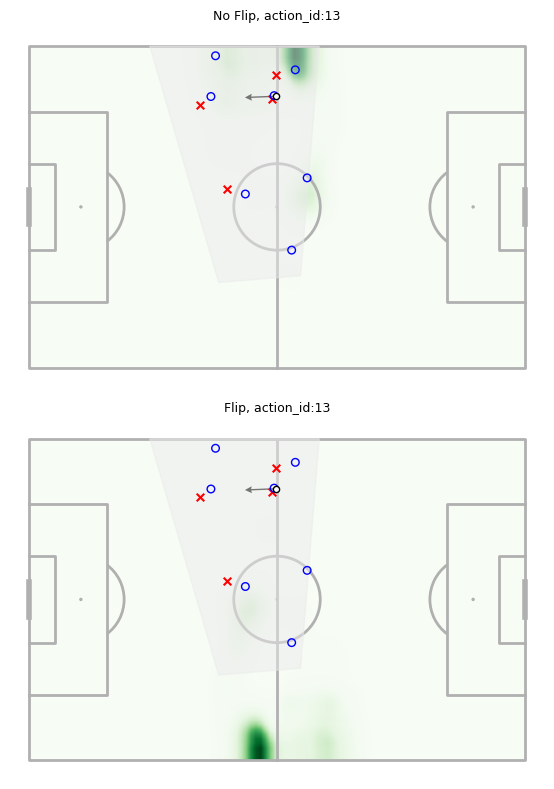

In [10]:
plot_selection(3795506, 13, surface_pass_selection)

In [41]:
#plot_selection(3795506, 13, surface_pass_selection)
import matplotlib
pdf = matplotlib.backends.backend_pdf.PdfPages("flipping.pdf")
for game_id, action_id in passes.index:
    print(game_id, action_id)
    pdf.savefig(plot_selection(game_id, action_id, surface_pass_selection))
pdf.close()

3795506 0
3795506 4
3795506 6
3795506 10
3795506 13
3795506 15
3795506 23
3795506 34
3795506 36
3795506 38
3795506 45
3795506 46
3795506 50
3795506 52
3795506 53
3795506 55
3795506 63
3795506 66
3795506 78
3795506 80
3795506 82


/tmp/ipykernel_1471997/554916299.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(2,1, figsize=(10,8))


3795506 87
3795506 89
3795506 94
3795506 96
3795506 98
3795506 100
3795506 102
3795506 104
3795506 106
3795506 108
3795506 121
3795506 131
3795506 145
3795506 149
3795506 160
3795506 162
3795506 164
3795506 177
3795506 179
3795506 180
3795506 182
3795506 193
3795506 198
3795506 200
3795506 204
3795506 216
3795506 220
3795506 222
3795506 224
3795506 226
3795506 228
3795506 232
3795506 234
3795506 246
3795506 248
3795506 251
3795506 253
3795506 255
3795506 257
3795506 261
3795506 263
3795506 265
3795506 269
3795506 271
3795506 273
3795506 275
3795506 277
3795506 282
3795506 284
3795506 286
3795506 288
3795506 295
3795506 297
3795506 299
3795506 301
3795506 303
3795506 309
3795506 311
3795506 317
3795506 319
3795506 336
3795506 338
3795506 347
3795506 348
3795506 352
3795506 355
3795506 357
3795506 361
3795506 367
3795506 369
3795506 373
3795506 375
3795506 377
3795506 379
3795506 381
3795506 387
3795506 388
3795506 391
3795506 393
3795506 402
3795506 403
3795506 411
3795506 412
3795506 4

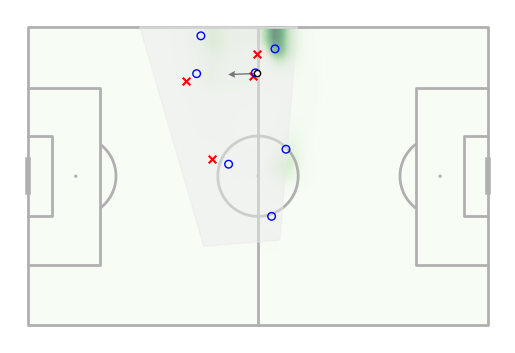

In [24]:
# Select an example pass
SAMPLE = (3795506, 13)
test = surface_pass_selection[SAMPLE[0]][SAMPLE[1]]#sometimes it gets flipped, others not?
test = np.flip(test)


ex_action = db.actions(game_id=SAMPLE[0]).loc[SAMPLE]
fig, ax = plt.subplots()
ax = plot_action(
    ex_action, surface=test, 
    show_visible_area=True, show_action=True,
    ax=ax, surface_kwargs={**plt_settings, "vmin": None, "vmax": None, "cmap": "Greens"}
)
plt.show()